In [1]:
# !pip install -q tensorflow==1.15.0
!pip install -q minio==5.0.6 #!!!!!!!!
!pip install -q rl_coach==1.0.0
!pip install -q exploration
!pip install -q gym==0.18.3
!pip install -q --quiet pogema

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pogema 1.0.1 requires gym>=0.18.3, but you have gym 0.12.5 which is incompatible.
  Using cached gym-0.18.3-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.12.5
    Uninstalling gym-0.12.5:
      Successfully uninstalled gym-0.12.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rl-coach 1.0.0 requires gym==0.12.5, but you have gym 0.18.3 which is incompatible.


In [2]:
# !pip uninstall gym -y
# # # !pip install gym==0.12.5
# !pip install gym==0.18.3


Found existing installation: gym 0.12.5
Uninstalling gym-0.12.5:
  Successfully uninstalled gym-0.12.5
  Using cached gym-0.18.3-py3-none-any.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rl-coach 1.0.0 requires gym==0.12.5, but you have gym 0.18.3 which is incompatible.


/root/miniconda3/envs/rl-coach/lib/python3.7/site-packages/drawSvg/raster.py:18: RuntimeWarning: Failed to import CairoSVG. drawSvg will be unable to output PNG or other raster image formats. See https://github.com/cduck/drawSvg#prerequisites for more details.
Original OSError: no library called "cairo-2" was found
no library called "cairo" was found
no library called "libcairo-2" was found
cannot load library 'libcairo.so.2': libcairo.so.2: cannot open shared object file: No such file or directory
cannot load library 'libcairo.2.dylib': libcairo.2.dylib: cannot open shared object file: No such file or directory
cannot load library 'libcairo-2.dll': libcairo-2.dll: cannot open shared object file: No such file or directory
  warnings.warn(msg, RuntimeWarning)


[0.0, 0.0, 0.0]
[1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 0.0]
[0.0, 1.0, 0.0]


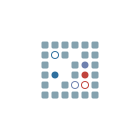

In [2]:
import gym
from pogema.wrappers.multi_time_limit import MultiTimeLimit
from pogema.animation import AnimationMonitor
from IPython.display import SVG, display
import numpy as np
import pogema
from pogema import GridConfig

# Define random configuration
grid_config = GridConfig(num_agents=3, # количество агентов на карте
                         size=4,      # размеры карты
                         density=0.4,  # плотность препятствий
                         seed=1,       # сид генерации задания 
                         max_episode_steps=256,  # максимальная длина эпизода
                         obs_radius=5, # радиус обзора
                        )

env = gym.make("Pogema-v0", grid_config=grid_config)
env = AnimationMonitor(env)

# # обновляем окружение
obs = env.reset()

done = [False, ...]

while not all(done):
    # Используем случайную стратегию
    obs, reward, done, info = env.step([np.random.randint(4) for _ in range(len(obs))])
    print(reward)
# сохраняем анимацию и рисуем ее
env.save_animation("render.svg", egocentric_idx=None)
display(SVG('render.svg'))

In [7]:
import os
import sys
import tensorflow as tf
module_path = os.path.abspath(os.path.join('..'))
resources_path = os.path.abspath(os.path.join('Resources'))
if module_path not in sys.path:
    sys.path.append(module_path)
if resources_path not in sys.path:
    sys.path.append(resources_path)

# env_params.level = "rl_coach.environments.pogema.envs:Pogema-v0"

In [3]:
from rl_coach.agents.dqn_agent import DQNAgentParameters
from rl_coach.base_parameters import VisualizationParameters, TaskParameters
from rl_coach.core_types import TrainingSteps, EnvironmentEpisodes, EnvironmentSteps
from rl_coach.environments.gym_environment import GymVectorEnvironment
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.memories.memory import MemoryGranularity


####################
# Graph Scheduling #
####################

# Resetting tensorflow graph as the network has changed.
# tf.reset_default_graph()

schedule_params = ScheduleParameters()
schedule_params.improve_steps = TrainingSteps(4000)
schedule_params.steps_between_evaluation_periods = EnvironmentEpisodes(10)
schedule_params.evaluation_steps = EnvironmentEpisodes(1)
schedule_params.heatup_steps = EnvironmentSteps(1000)

#########
# Agent #
#########
agent_params = DQNAgentParameters()

# DQN params
agent_params.algorithm.num_steps_between_copying_online_weights_to_target = EnvironmentSteps(100)
agent_params.algorithm.discount = 0.99
agent_params.algorithm.num_consecutive_playing_steps = EnvironmentSteps(1)

# NN configuration
agent_params.network_wrappers['main'].learning_rate = 0.00025
agent_params.network_wrappers['main'].replace_mse_with_huber_loss = False

# ER size
agent_params.memory.max_size = (MemoryGranularity.Transitions, 40000)

################
#  Environment #
################
# env_params = GymEnvironmentParameters()
env_params = GymVectorEnvironment()
env_params.level = env

In [15]:
# from Resources.exploration import MyExplorationParameters

# Overriding the default DQN Agent exploration policy with my exploration policy
# agent_params.exploration = MyExplorationParameters()

# Creating a graph manager to train a DQN agent to solve CartPole
graph_manager = BasicRLGraphManager(agent_params=agent_params, env_params=env_params,
                                    schedule_params=schedule_params, vis_params=VisualizationParameters())

# Resources path was defined at the top of this notebook
my_checkpoint_dir = resources_path + '/checkpoints'

# Checkpoints will be stored every 5 seconds to the given directory
task_parameters1 = TaskParameters()
task_parameters1.checkpoint_save_dir = my_checkpoint_dir
task_parameters1.checkpoint_save_secs = 5

graph_manager.create_graph(task_parameters1)
graph_manager.improve()


Creating graph - name: BasicRLGraphManager


Error: Attempted to look up malformed environment ID: b'<AnimationMonitor<MetricsWrapper<MultiTimeLimit<Pogema<Pogema-v0>>>>>'. (Currently all IDs must be of the form ^(?:[\w:-]+\/)?([\w:.-]+)-v(\d+)$.)

In [9]:
print(sys.path)

['/root/project/wall-e-robot/Jupyter Notebook', '/root/miniconda3/envs/rl-coach/lib/python37.zip', '/root/miniconda3/envs/rl-coach/lib/python3.7', '/root/miniconda3/envs/rl-coach/lib/python3.7/lib-dynload', '', '/root/miniconda3/envs/rl-coach/lib/python3.7/site-packages', '/root/miniconda3/envs/rl-coach/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython', '/root/project/wall-e-robot', '/root/project/wall-e-robot/Jupyter Notebook/Resources']


In [12]:
os.getcwd()

'/root/project/wall-e-robot/Jupyter Notebook'